## Compare CatBoost in the case of binary class (Sell, Buy)

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_catboost,
)

In [115]:
metric = "precision"
test_size = 300

In [116]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [117]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [118]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [119]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [120]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [121]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [123]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 21:07:52,976] A new study created in memory with name: no-name-edcfec0b-3487-4dc9-8a29-a91b3c90c6d7
[I 2024-02-13 21:07:55,966] Trial 0 finished with value: 0.52761555473512 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.013134490997020746, 'learning_rate': 0.04023666959052234, 'depth': 10, 'boosting_type': 'Plain', 'l2_leaf_reg': 7, 'min_data_in_leaf': 26, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.52761555473512.
[I 2024-02-13 21:08:04,647] Trial 1 finished with value: 0.5493125772531864 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04602473392645539, 'learning_rate': 0.01924372468215592, 'depth': 3, 'boosting_type': 'Ordered', 'l2_leaf_reg': 7, 'min_data_in_leaf': 85, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.650437819689809}. Best is trial 1 with value: 0.5493125772531864.
[I 2024-02-13 21:08:13,042] Trial 2 finished with value: 0.5445001874847276 and parameters: {'objective': 'Logloss', 'colsample_byle

Number of finished trials: 72
Best trial:
  Value: 0.6474280925459148
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09292528993648504
    learning_rate: 0.08859378167647158
    depth: 9
    boosting_type: Ordered
    l2_leaf_reg: 4
    min_data_in_leaf: 12
    bootstrap_type: Bernoulli
    subsample: 0.5572815429802075


In [124]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **trial.params
                | {
                    "used_ram_limit": "3gb",
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [125]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x134b89dd0>)])

In [126]:
predictions = pipe.predict(X_test)

In [127]:
# In-sample score
pipe.score(X_train, y_train)

0.7855902777777778

In [128]:
# Out-of-sample score
pipe.score(X_test, y_test)

0.5133333333333333

              precision    recall  f1-score   support

           0       0.60      0.41      0.49       170
           1       0.46      0.65      0.54       130

    accuracy                           0.51       300
   macro avg       0.53      0.53      0.51       300
weighted avg       0.54      0.51      0.51       300



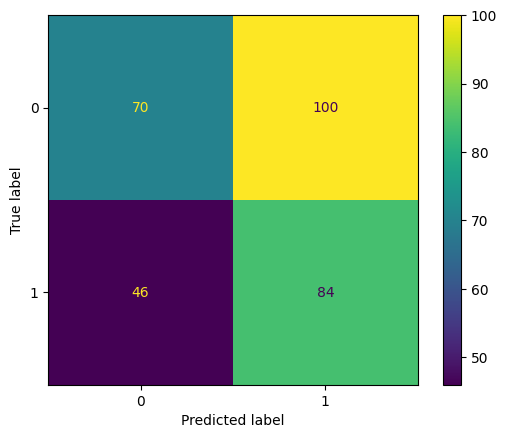

In [129]:
display_report(y_test, predictions)

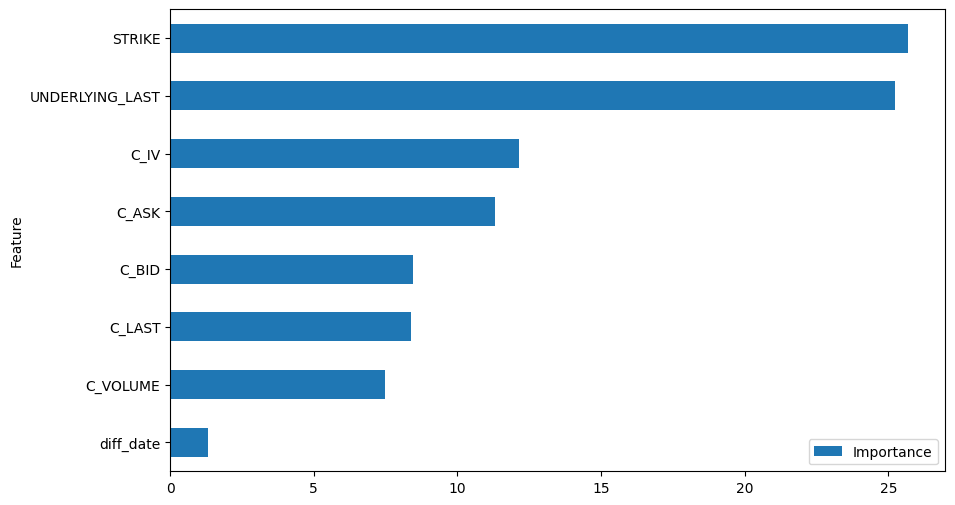

In [130]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [131]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [132]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [133]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.00,-7.580000,0.000000,-7.580000
2022-08-05,1,413.0,7.66,2022-08-26,405.309998,-7.66,-7.660000,-7.660000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.00,-7.440000,-7.660000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.00,-7.510000,-7.660000,-30.190000
2022-08-10,0,420.0,6.90,2022-08-31,395.179993,0.00,-6.900000,-7.660000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,99.439985,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,99.439985,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,99.439985,126.819912


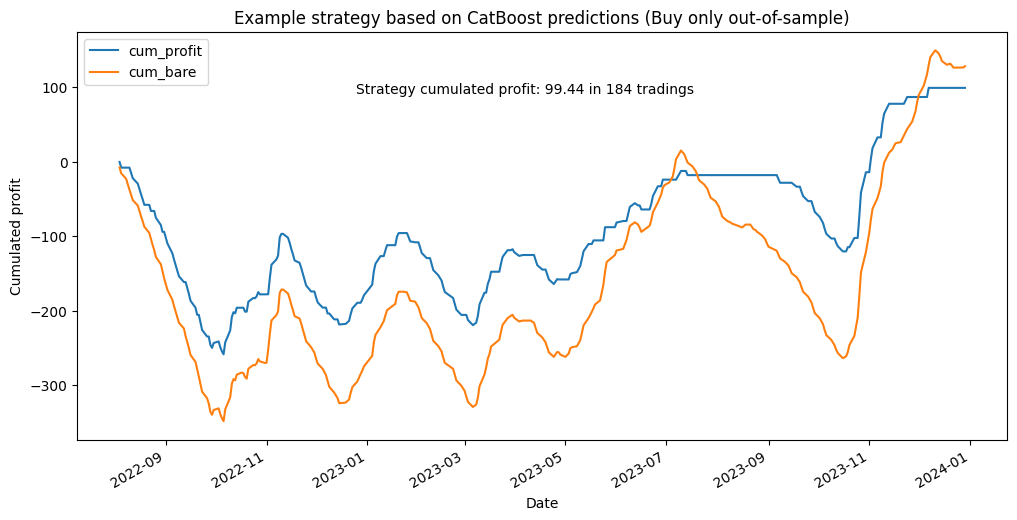

In [134]:
plot_strategy(strategy_df, "CatBoost", "(Buy only out-of-sample)")

In [135]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## CatBoost with data from MC simulation and additional features

In [136]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [137]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [139]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-13 21:18:00,012] A new study created in memory with name: no-name-b20e8e23-d05f-4a50-aacb-fe8c64306a87


[I 2024-02-13 21:18:02,724] Trial 0 finished with value: 0.5470593031748767 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.016746349100401063, 'learning_rate': 0.0010573717049530641, 'depth': 3, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 57, 'bootstrap_type': 'Bernoulli', 'subsample': 0.12687763002549576}. Best is trial 0 with value: 0.5470593031748767.
[I 2024-02-13 21:19:14,959] Trial 1 finished with value: 0.6602631970901209 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08892989594427868, 'learning_rate': 0.0026788267671530594, 'depth': 11, 'boosting_type': 'Ordered', 'l2_leaf_reg': 4, 'min_data_in_leaf': 60, 'bootstrap_type': 'Bernoulli', 'subsample': 0.22276987226549322}. Best is trial 1 with value: 0.6602631970901209.
[I 2024-02-13 21:19:17,326] Trial 2 finished with value: 0.5700507832995184 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.017694622120138365, 'learning_rate': 0.007955766391394524, '

Number of finished trials: 48
Best trial:
  Value: 0.7570902316128214
  Params: 
    objective: Logloss
    colsample_bylevel: 0.08694134370145191
    learning_rate: 0.05950880884949578
    depth: 9
    boosting_type: Ordered
    l2_leaf_reg: 5
    min_data_in_leaf: 51
    bootstrap_type: MVS


In [140]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [141]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x1347c8150>)])

In [142]:
predictions = pipe.predict(X_test)

In [143]:
# In-sample score
pipe.score(X_train, y_train)

0.9869791666666666

In [144]:
# Out-of-sample score
pipe.score(X_test, y_test)

0.4766666666666667

              precision    recall  f1-score   support

           0       0.60      0.22      0.33       170
           1       0.44      0.81      0.57       130

    accuracy                           0.48       300
   macro avg       0.52      0.52      0.45       300
weighted avg       0.53      0.48      0.43       300



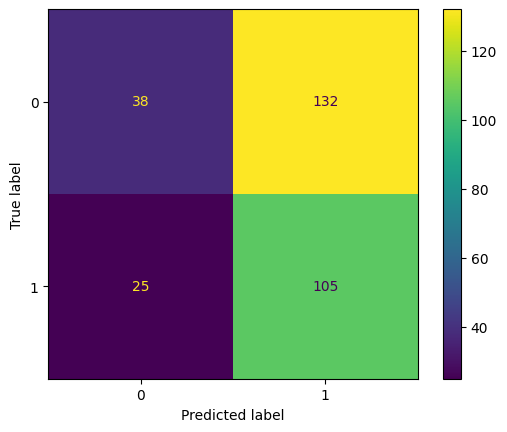

In [145]:
display_report(y_test, predictions)

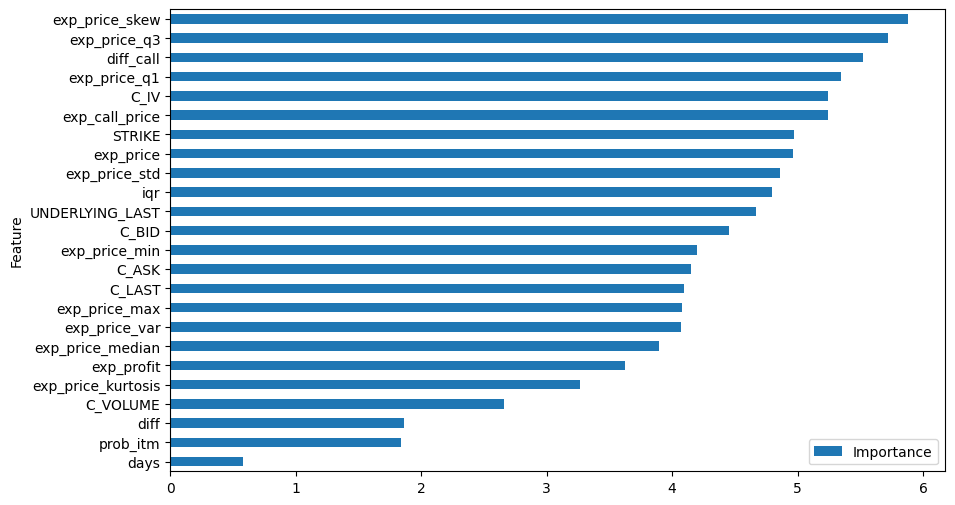

In [146]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [147]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [148]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [149]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.00,-7.580000,0.000000,-7.580000
2022-08-05,1,413.0,7.66,2022-08-26,405.309998,-7.66,-7.660000,-7.660000,-15.240000
2022-08-08,1,413.0,7.44,2022-08-29,402.630005,-7.44,-7.440000,-15.100000,-22.680000
2022-08-09,1,411.0,7.51,2022-08-29,402.630005,-7.51,-7.510000,-22.610000,-30.190000
2022-08-10,1,420.0,6.90,2022-08-31,395.179993,-6.90,-6.900000,-29.510000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.00,-2.390007,127.110018,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,127.110018,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,127.110018,126.819912


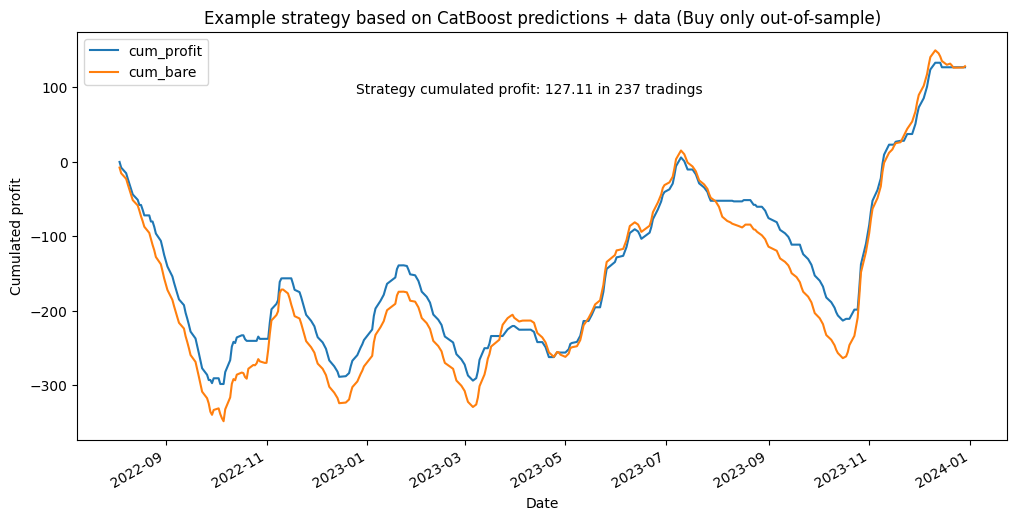

In [150]:
plot_strategy(strategy_df, "CatBoost", "+ data (Buy only out-of-sample)")

In [151]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [152]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [153]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
2,0,-7.660000,1,-15.100000,-22.680000
3,0,-7.660000,1,-22.610000,-30.190000
4,0,-7.660000,1,-29.510000,-37.090000
9,1,-43.570000,0,-57.760000,-73.000000
15,0,-65.810000,1,-87.010000,-118.440000
...,...,...,...,...,...
285,0,87.179988,1,85.570028,102.239951
286,0,87.179988,1,101.050026,117.719949
288,0,99.439985,1,124.060021,140.729944
289,0,99.439985,1,133.170018,149.839941


In [154]:
compare_df[mask_out].shape

(99, 5)

In [155]:
compare_df.sum(axis=0)

bare_rf_pred_out         184.000000
cum_profit_out        -28101.957006
mmar_rf_pred_out         237.000000
mmar_cum_profit_out   -43284.712795
mmar_cum_bare_out     -49180.449390
dtype: float64

<Axes: >

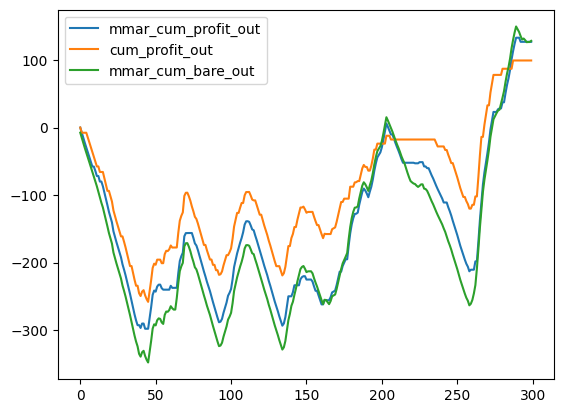

In [156]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].plot()

In [157]:
pipe.predict_proba(X_test)

array([[0.63640328, 0.36359672],
       [0.483155  , 0.516845  ],
       [0.47132824, 0.52867176],
       [0.43494773, 0.56505227],
       [0.41578929, 0.58421071],
       [0.17048298, 0.82951702],
       [0.36659513, 0.63340487],
       [0.16584698, 0.83415302],
       [0.19581722, 0.80418278],
       [0.59356407, 0.40643593],
       [0.22500696, 0.77499304],
       [0.23026107, 0.76973893],
       [0.62930571, 0.37069429],
       [0.3507338 , 0.6492662 ],
       [0.54306089, 0.45693911],
       [0.47453803, 0.52546197],
       [0.16192096, 0.83807904],
       [0.47622979, 0.52377021],
       [0.46303997, 0.53696003],
       [0.37709834, 0.62290166],
       [0.43016709, 0.56983291],
       [0.36635893, 0.63364107],
       [0.44723643, 0.55276357],
       [0.21608041, 0.78391959],
       [0.45754353, 0.54245647],
       [0.35070163, 0.64929837],
       [0.13502453, 0.86497547],
       [0.19741623, 0.80258377],
       [0.35458672, 0.64541328],
       [0.20014409, 0.79985591],
       [0.

In [158]:
df_proba = pd.DataFrame(pipe.predict_proba(X_test), columns=["class_0", "class_1"])
df_proba["pred"] = predictions
df_proba["true"] = y_test

In [159]:
from sklearn.metrics import roc_curve

In [160]:
def select_treshold(proba, target, fpr_max=0.1):
    # calculate roc curves
    fpr, _, thresholds = roc_curve(target, proba)
    # get the best threshold with fpr <=0.1
    best_treshold = thresholds[fpr <= fpr_max][-1]

    return best_treshold

In [169]:
select_treshold(pipe.predict_proba(X_test)[:, 1], y_test, fpr_max=0.15)

0.853455240343849

In [ ]:
def select_treshold2(proba, target, tpr_max=0.75):
    # calculate roc curves
    _, tpr, thresholds = roc_curve(target, proba)
    # get the best threshold with fpr <=0.1
    best_treshold = thresholds[tpr >= tpr_max][-1]

    return best_treshold

In [ ]:
select_treshold2(pipe.predict_proba(X_test)[:, 1], y_test, tpr_max=0.75)

In [162]:
df_proba

,class_0,class_1,pred,true
0,0.636403,0.363597,0,0
1,0.483155,0.516845,1,0
2,0.471328,0.528672,1,0
3,0.434948,0.565052,1,0
4,0.415789,0.584211,1,0
...,...,...,...,...
295,0.935030,0.064970,0,0
296,0.954726,0.045274,0,0
297,0.988495,0.011505,0,1
298,0.990048,0.009952,0,0


In [170]:
pipe.named_steps["rf"].set_probability_threshold(0.85)

In [171]:
new_preds = pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       170
           1       0.66      0.38      0.48       130

    accuracy                           0.65       300
   macro avg       0.65      0.61      0.61       300
weighted avg       0.65      0.65      0.62       300



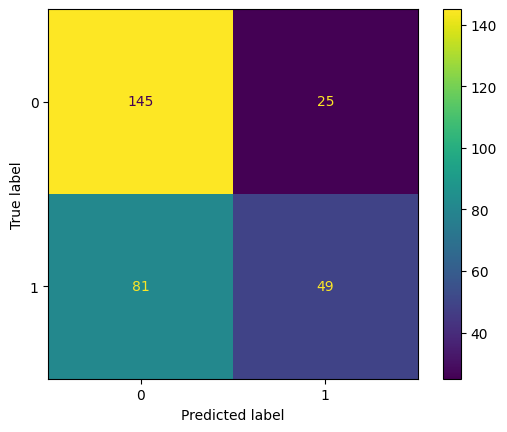

In [172]:
display_report(y_test, new_preds)

In [173]:
strategy_df = backtest_strategy(new_preds, X_test, spy, ml_df)

In [174]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-04,0,414.0,7.58,2022-08-24,413.670013,0.0,-7.580000,0.000000,-7.580000
2022-08-05,0,413.0,7.66,2022-08-26,405.309998,0.0,-7.660000,0.000000,-15.240000
2022-08-08,0,413.0,7.44,2022-08-29,402.630005,0.0,-7.440000,0.000000,-22.680000
2022-08-09,0,411.0,7.51,2022-08-29,402.630005,0.0,-7.510000,0.000000,-30.190000
2022-08-10,0,420.0,6.90,2022-08-31,395.179993,0.0,-6.900000,0.000000,-37.090000
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.0,-2.390007,331.879965,129.599927
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,331.879965,126.579919
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,331.879965,126.819912


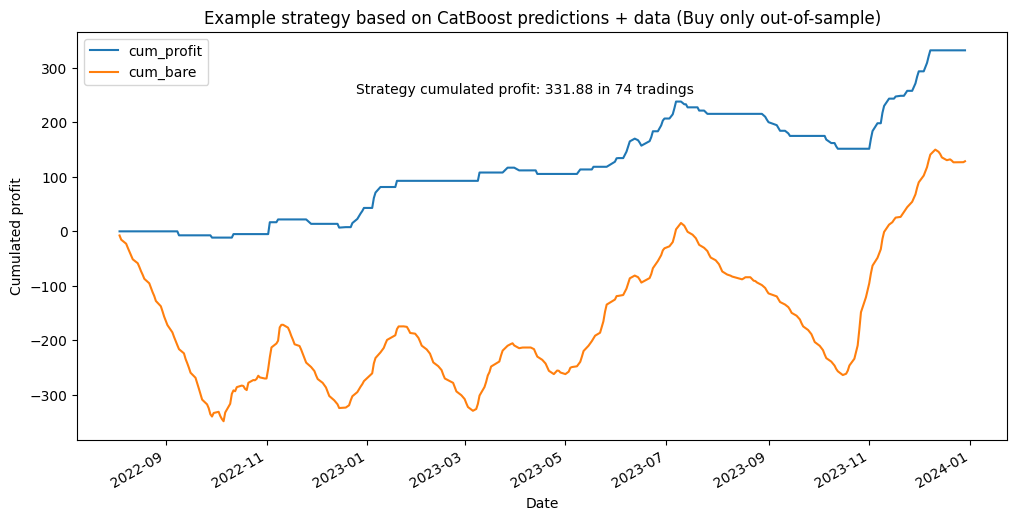

In [175]:
plot_strategy(strategy_df, "CatBoost", "+ data (Buy only out-of-sample)")